# 大纲

In [ ]:
# 论文Background and foreground modeling using nonparametric kernel density estimation for visual surveillance 指出相邻的像素是服从正态分布
# 改进1 第一帧和平均帧（均值）的差 是服从X ~ N(μ=0, σ^2=σ_1^2+σ_2^2) 表示差值服从均值为0，方差为2σ^2的正态分布
# 阈值1 如果超过方差 σ_1^2+σ_2^2 则认为是非正常波动，但是由于其摄像机的噪声分布并不服从X2 - X1的正太分布
# 改进2 第一帧和平均帧（均值）的差拆解为 ./utils/statistic.py 公式中 (first_X - X_bar) + (X_bar - mean)，分别用两个阈值来控制物体的运动
# 创新点1：其中 threshold1 = first_X - X_bar 表示当前帧与第一帧的差值； threshold2 = X_bar - mean 表示当前帧与均值的差值 ，我们将在第二帧应用t值的假设检验
# 见章节3
# 创新点2：采用噪音修正后的均值填充，有效的解决了样本之间的色差问题
# 见章节4
# 创新点3：能够高效的建模出前景，并时候修正后的均值进行填充，取得较好的结果
# 实验发现 用两个阈值可以很好的去除掉图片中运动较为快速，保留运动较为缓慢的物体（如旗帜飘飘，人缓慢的移动）

# 代码实现

In [1]:
import os
os.chdir('../')
print("当前工作目录已更改为:", os.getcwd())
import cv2
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import utils.statistic as statistic

当前工作目录已更改为: /home/byh/Tears-illusion-


## 1. 计算均值方差

In [225]:
# 计算均值图片的方差

folder_path = '/home/byh/Tears-illusion-/data/output/frame'

# 视频每一帧图片
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

frames_list = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    if image is not None:
        frames_list.append(image)
        
images_array = np.array(frames_list)

# 计算每个像素点的均值和方差
pixel_mean = np.mean(images_array, axis=0)
pixel_variance = np.var(images_array, axis=0)

  0%|          | 0/133 [00:00<?, ?it/s]

100%|██████████| 133/133 [00:00<00:00, 429.18it/s]


In [17]:
# 异常值检测
# 均值
print(f'均值 超过255的像素点的个数{np.sum(pixel_mean > 255)}')
print(f'均值 小于0的像素点的个数{np.sum(pixel_mean < 0)}')
# 方差
print(f'均值 超过255的像素点的个数{np.sum(pixel_variance > 255)}') # 方差波动较大，一场值较多，在图片中255以上都将刻画为白色
print(f'均值 小于0的像素点的个数{np.sum(pixel_variance < 0)}')

均值 超过255的像素点的个数0
均值 小于0的像素点的个数0
均值 超过255的像素点的个数203903
均值 小于0的像素点的个数0


## 2.可视化均值方差

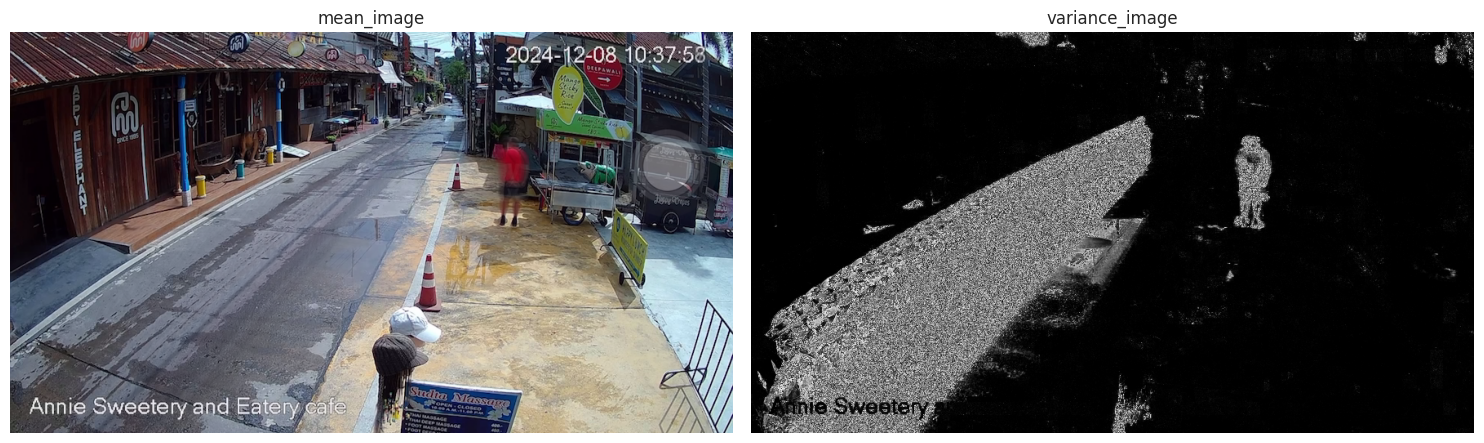

In [21]:
# 显示统计指标  视频均值和方差(注：这里的均值和方差从图片中读取，而原始的方差并没有标准化到unit8范围之内，在后续建模过程会出现一定的问题，这里只是可视化展示一下)
mean = cv2.imread('../data/output/statistics/mean_image.png')
std = cv2.imread('../data/output/statistics/variance_image.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(mean, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('mean_image')

ax[1].imshow(std, cmap='gray')
ax[1].axis('off')
ax[1].set_title('variance_image')


plt.tight_layout()
plt.show()


## 3.单像素点建模

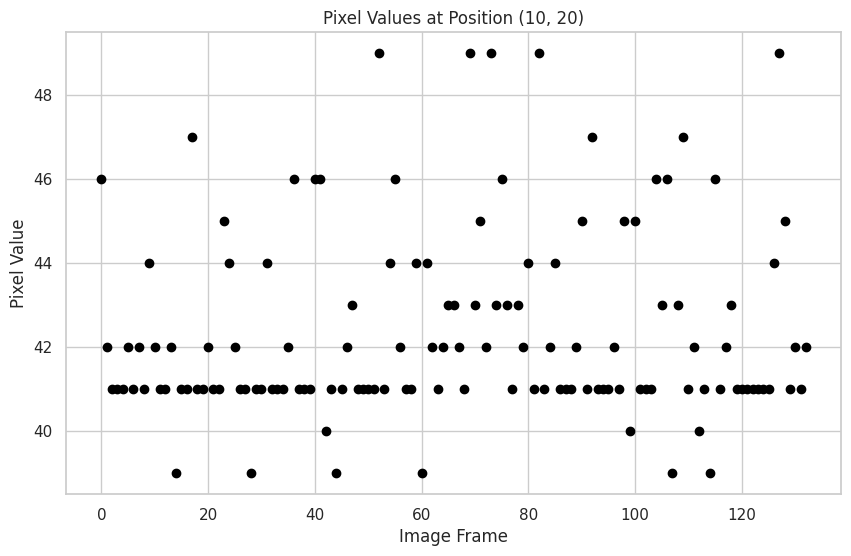

In [19]:
# 像素点随时间变化图
# 刻画单个像素点变化
folder_path = '/home/byh/Tears-illusion-/data/output/frame'
pixel_values = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'): 
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        pixel_value = img[20, 20]
        pixel_values.append(pixel_value)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(pixel_values)), pixel_values, color='black')
plt.title('Pixel Values at Position (10, 20)')
plt.xlabel('Image Frame')
plt.ylabel('Pixel Value')
plt.show()


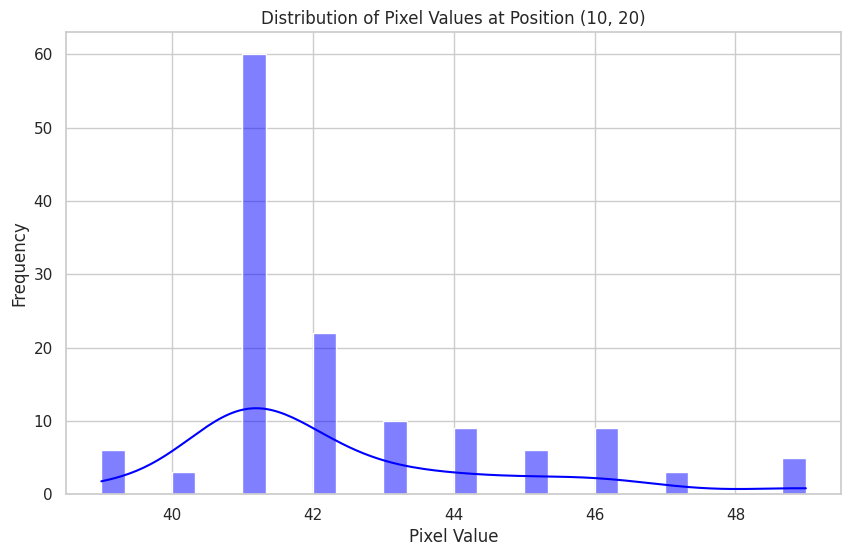

In [ ]:
# 创新点1 将假设检验引入 单像素点 阈值中，超过3σ，则拒绝原假设，我们假设alpha为0.05，则可以获得99.73%的置信度
# 修改1:把图画的更好看，加入假设检验的的图片，可放入论文
folder_path = '/home/byh/Tears-illusion-/data/output/frame'
pixel_values = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        pixel_value = img[20, 20]  #（宽，长）
        pixel_values.append(pixel_value)

pixel_values = np.array(pixel_values)

# 使用Seaborn绘制直方图和核密度估计图
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(pixel_values, kde=True, bins=30, color='blue')
plt.title('Distribution of Pixel Values at Position (10, 20)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


## 4.前景建模

In [145]:
# 要处理的帧
X_bar = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00009.jpg', cv2.IMREAD_GRAYSCALE)
# 标准帧
standard_X = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00050.jpg', cv2.IMREAD_GRAYSCALE)
# 均值帧
mean = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/mean_image.png', cv2.IMREAD_GRAYSCALE)
# 方差帧
var = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/variance_image.png', cv2.IMREAD_GRAYSCALE)

n = 132 # 自由度 n-1 ——n：总帧数
# threshold 这个函数将输出三个阈值，接下来将分别进行动态展示
mask1, mask2, mask = statistic.threshold(X_bar, standard_X, mean, var, n)


### 1.阈值1的建模值

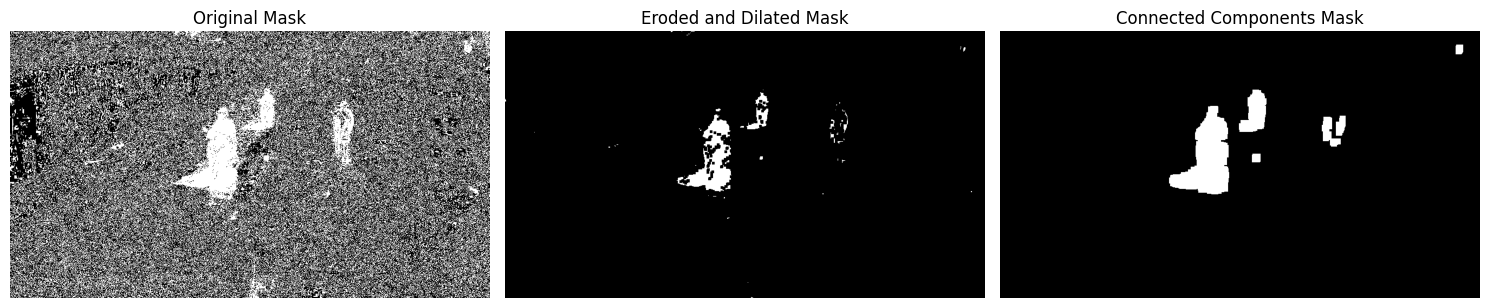

In [154]:
# 阈值1 的前景建模过程图

mask1_O = mask1.astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8) 
mask1_E = cv2.erode(mask1_O, kernel=kernel, iterations=2)  # 腐蚀
mask1_dcc,_,_ = statistic.detect_connected_components(mask1_E,20,100)
mask1_d = cv2.dilate(np.array(mask1_dcc, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=1)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# 显示原始 mask
ax[0].imshow(mask1_O, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Mask')
# 显示腐蚀后的 mask
ax[1].imshow(mask1_E, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Eroded and Dilated Mask')
# 显示连通组件检测后的 mask
ax[2].imshow(mask1_d, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Connected Components Mask')

plt.tight_layout()
plt.show()

### 2.阈值2的建模值

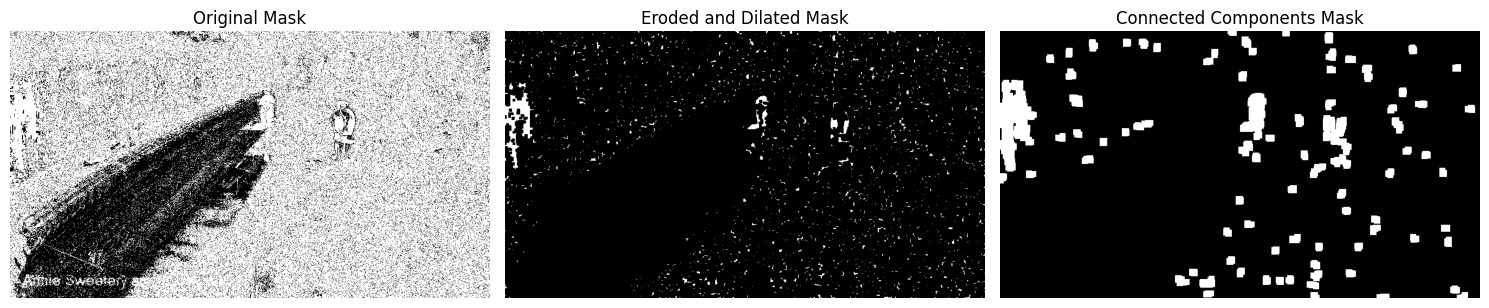

In [155]:
# 阈值2 的前景建模过程图

mask2_O = mask2.astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8) 

mask2_E = cv2.erode(mask2_O, kernel=kernel, iterations=2)  # 腐蚀
mask2_dcc,_,_ = statistic.detect_connected_components(mask2_E,10,100)
mask2_d = cv2.dilate(np.array(mask2_dcc, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=1)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# 显示原始 mask
ax[0].imshow(mask2_O, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Mask')
# 显示腐蚀后的 mask
ax[1].imshow(mask2_E, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Eroded and Dilated Mask')
# 显示连通组件检测后的 mask
ax[2].imshow(mask2_d, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Connected Components Mask')

plt.tight_layout()
plt.show()

### 阈值3的建模

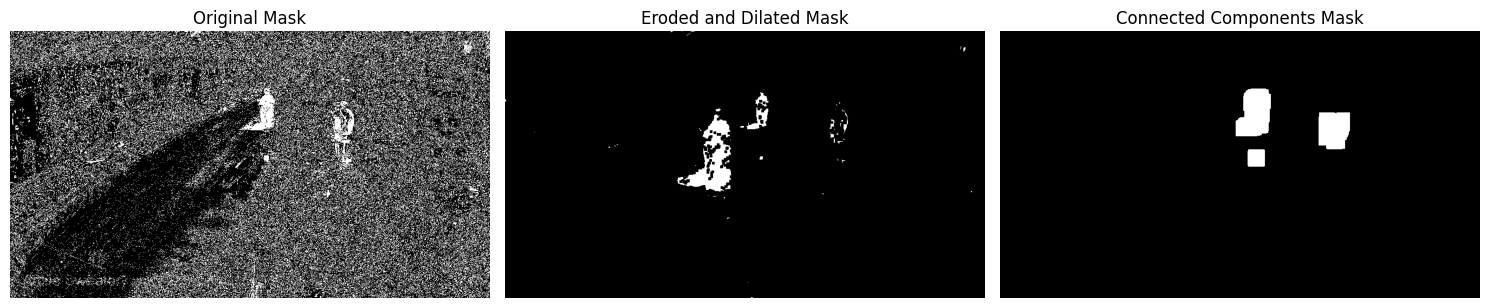

In [156]:
# 阈值3 的前景建模过程图

mask_O = mask.astype(np.uint8) * 255

kernel = np.ones((5, 5), np.uint8) 

mask_E = mask1_E * mask1_E

mask_d = mask1_d * mask2_d
mask_d = cv2.dilate(np.array(mask_d, dtype=np.uint8) * 255, np.ones((5, 5), np.uint8) , iterations=4)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# 显示原始 mask
ax[0].imshow(mask_O, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Mask')
# 显示腐蚀后的 mask
ax[1].imshow(mask_E, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Eroded and Dilated Mask')
# 显示连通组件检测后的 mask
ax[2].imshow(mask_d, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Connected Components Mask')

plt.tight_layout()
plt.show()

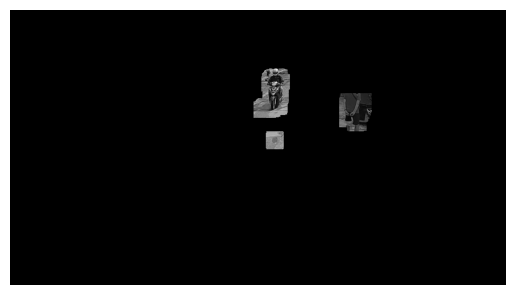

In [157]:
mask2image = cv2.bitwise_and(X_bar, X_bar, mask=mask_d)
# 显示结果
plt.imshow(cv2.cvtColor(mask2image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 不显示坐标轴
plt.show()

## 5.调整均值

### 1.连通区域法

### 2.噪声修正法

In [15]:
# 创新点2 基于时刻的均值调整
# 通俗说就是在那个时刻的帧中加入一定的噪声，让其分布更靠近原图，使得色差不再明显

def adjust_mean(mean, frame, mask):
    # 调整均值
    # 计算掩码区域内和掩码区域外的灰度值平均值
    # 掩码区域内的像素
    masked_pixels = frame[mask == 1]
    avg_gray_masked = np.mean(masked_pixels) if masked_pixels.size > 0 else 0
    
    # 掩码区域外的像素
    unmasked_pixels = self.grey_mean[mask == 0]
    avg_gray_unmasked = np.mean(unmasked_pixels) if unmasked_pixels.size > 0 else 0
    
    # # 输出计算出的两个平均值（掩码区域内和外的平均灰度值）
    # print("掩码区域内的平均灰度值:", avg_gray_masked)
    # print("掩码区域外的平均灰度值:", avg_gray_unmasked)
    return ((avg_gray_masked - avg_gray_unmasked) / np.mean(np.sqrt(self.var))) * 2.5

None


/home/byh/Tears-illusion-/utils/statistic.py:27: RuntimeWarning: divide by zero encountered in divide
  t_statistic = (X_bar - mean) / (variance / (n ** 0.5))
/home/byh/Tears-illusion-/utils/statistic.py:27: RuntimeWarning: invalid value encountered in divide
  t_statistic = (X_bar - mean) / (variance / (n ** 0.5))


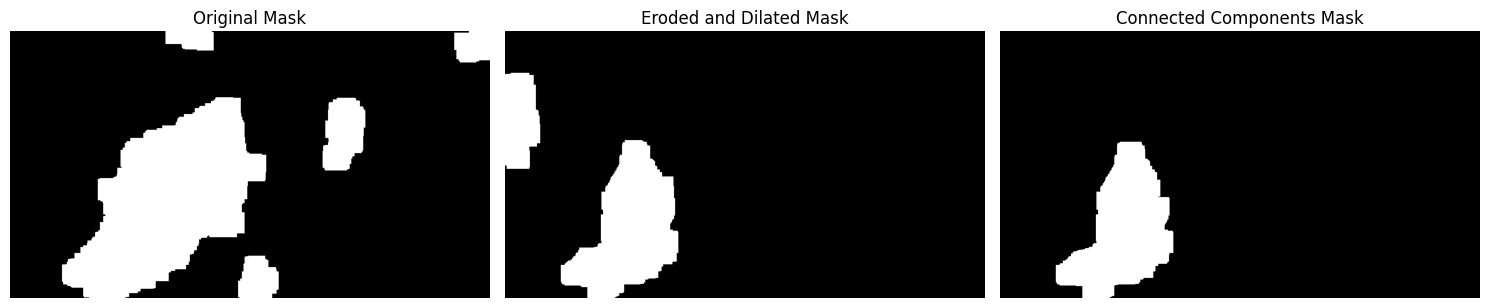

In [3]:
X_bar = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00100.jpg', cv2.IMREAD_GRAYSCALE)
standard_X = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00050.jpg', cv2.IMREAD_GRAYSCALE)
mean = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/mean_image.png', cv2.IMREAD_GRAYSCALE)
var = cv2.imread('/home/byh/Tears-illusion-/data/output/statistics/variance_image.png', cv2.IMREAD_GRAYSCALE)

n = 133
mask1, mask2, mask = statistic.threshold(X_bar, standard_X, mean, var, n)

# 将布尔mask转换为uint8类型，True为255，False为0
mask_uint8 = mask.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask_uint8, dtype=np.uint8) * 255
mask_uint8 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask_uint8 = statistic.detect_connected_components(mask_uint8,125,100)
mask_uint8 = cv2.dilate(np.array(mask_uint8, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)

# 将布尔mask1转换为uint8类型，True为255，False为0
mask_1 = mask1.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask1, dtype=np.uint8) * 255
mask1 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask1 = statistic.detect_connected_components(mask1,80,100)
mask1 = cv2.dilate(np.array(mask1, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)

# 将布尔mask2转换为uint8类型，True为255，False为0
mask2 = mask2.astype(np.uint8) * 255
kernel = np.ones((5, 5), np.uint8) 
outliersa = np.array(mask2, dtype=np.uint8) * 255
mask2 = cv2.erode(outliersa, kernel=kernel, iterations=1)  # 腐蚀
mask2 = statistic.detect_connected_components(mask2,80,100)
mask2 = cv2.dilate(np.array(mask2, dtype=np.uint8) * 255, np.ones((11, 11), np.uint8) , iterations=3)
# 使用 matplotlib 显示图像
# 使用 matplotlib 显示图像
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 显示原始 mask
ax[0].imshow(mask1, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original Mask')

# 显示腐蚀后的 mask
ax[1].imshow(mask2, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Eroded and Dilated Mask')

# 显示连通组件检测后的 mask
ax[2].imshow(mask_uint8, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Connected Components Mask')

plt.tight_layout()
plt.show()

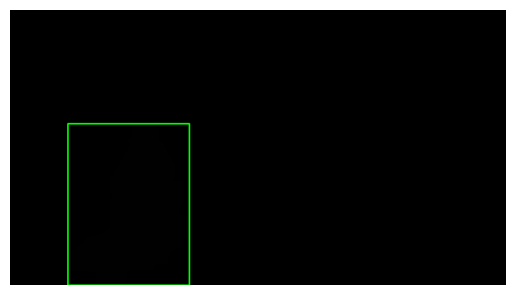

In [14]:
plt.imshow(a)
plt.axis('off')  # 不显示坐标轴
plt.show()

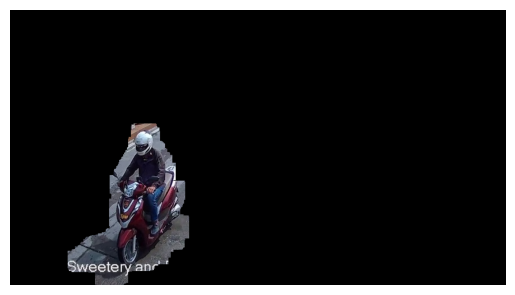

In [18]:
image = cv2.imread('/home/byh/Tears-illusion-/data/output/frame/00100.jpg')
mask2image = cv2.bitwise_and(image, image, mask=mask_uint8)
# 显示结果
plt.imshow(cv2.cvtColor(mask2image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 不显示坐标轴
plt.show()
